In [1]:
import torch
from monai.visualize import GradCAM,ModelWithHooks
from monai.networks.nets import DenseNet121
import matplotlib.pyplot as plt
import numpy as np
from monai.transforms import (
    EnsureChannelFirst,
    Compose,
    Resize,
    ScaleIntensity,
    EnsureChannelFirst,
    Compose,
    LoadImage,
)
import SimpleITK as sitk
import cv2

In [2]:
image_path = "/data/Ziliang/IPMN_cysts_20240909/deeplearning/ROI/nyu_0173.nii.gz"  # or .nii
image = sitk.ReadImage(image_path)
image_array = sitk.GetArrayFromImage(image)  # shape: (D, H, W)
image_array = np.transpose(image_array, (2, 1, 0))  # shape: (H, W, D)
preprocess = Compose([
    LoadImage(image_only=True),
    ScaleIntensity(),              # Normalize intensity range (e.g., [0, 1])
    EnsureChannelFirst(),          # Ensures shape: (C, H, W, D)
    Resize((96, 96, 96))           # Resizes the volume to fixed spatial size
])
Resizer = Resize(image_array.shape)
input_tensor = preprocess(image_path)  # shape: (1, H, W, D)
input_tensor = input_tensor.unsqueeze(0)

In [3]:
model = DenseNet121(
        spatial_dims=3,  # 3D input
        in_channels=1,   # Typically for grayscale (e.g., MRI/CT scans), change to 3 for RGB
        out_channels=2,   # Adjust for binary or multi-class segmentation/classification 
    )

model.load_state_dict(torch.load("/data/Ziliang/IPMN_cysts_20240909/DenseNet121_weights/model_loss_Train_Test_4_fold0.pth"))
model.eval().cuda()

/tmp/ipykernel_90891/32719741.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/data/Ziliang/IPMN_cysts_20240909/DenseNet121_weights/mod

DenseNet121(
  (features): Sequential(
    (conv0): Conv3d(1, 64, kernel_size=(7, 7, 7), stride=(2, 2, 2), padding=(3, 3, 3), bias=False)
    (norm0): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool3d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (layers): Sequential(
          (norm1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv3d(64, 128, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
          (norm2): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv3d(128, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        )
      )
      (denselayer2): _DenseLayer(
        (layers): Sequential(
 

In [4]:
from monai.visualize.class_activation_maps import GradCAM

# Just use your original model
cam = GradCAM(
    nn_module=model,
    target_layers=["features.denseblock4.denselayer16.layers.conv2"]
)

# ---------------------------
# Run it
class_idx = 1
input_tensor = input_tensor.to('cuda')
cam_output = cam(input_tensor, class_idx=class_idx)

In [5]:
cam_volume = cam_output[0].detach().cpu()  # shape: (H, W, D)
cam_volume = cam_volume.squeeze().cpu()  # Remove batch dimension
input_tensor = input_tensor.squeeze().cpu()  # shape: (H, W, D)
input_tensor = Resizer(input_tensor.unsqueeze(0)).squeeze().numpy()  # Resize to original shape
cam_volume = Resizer(cam_volume.unsqueeze(0)).squeeze().numpy() # Resize to original shape

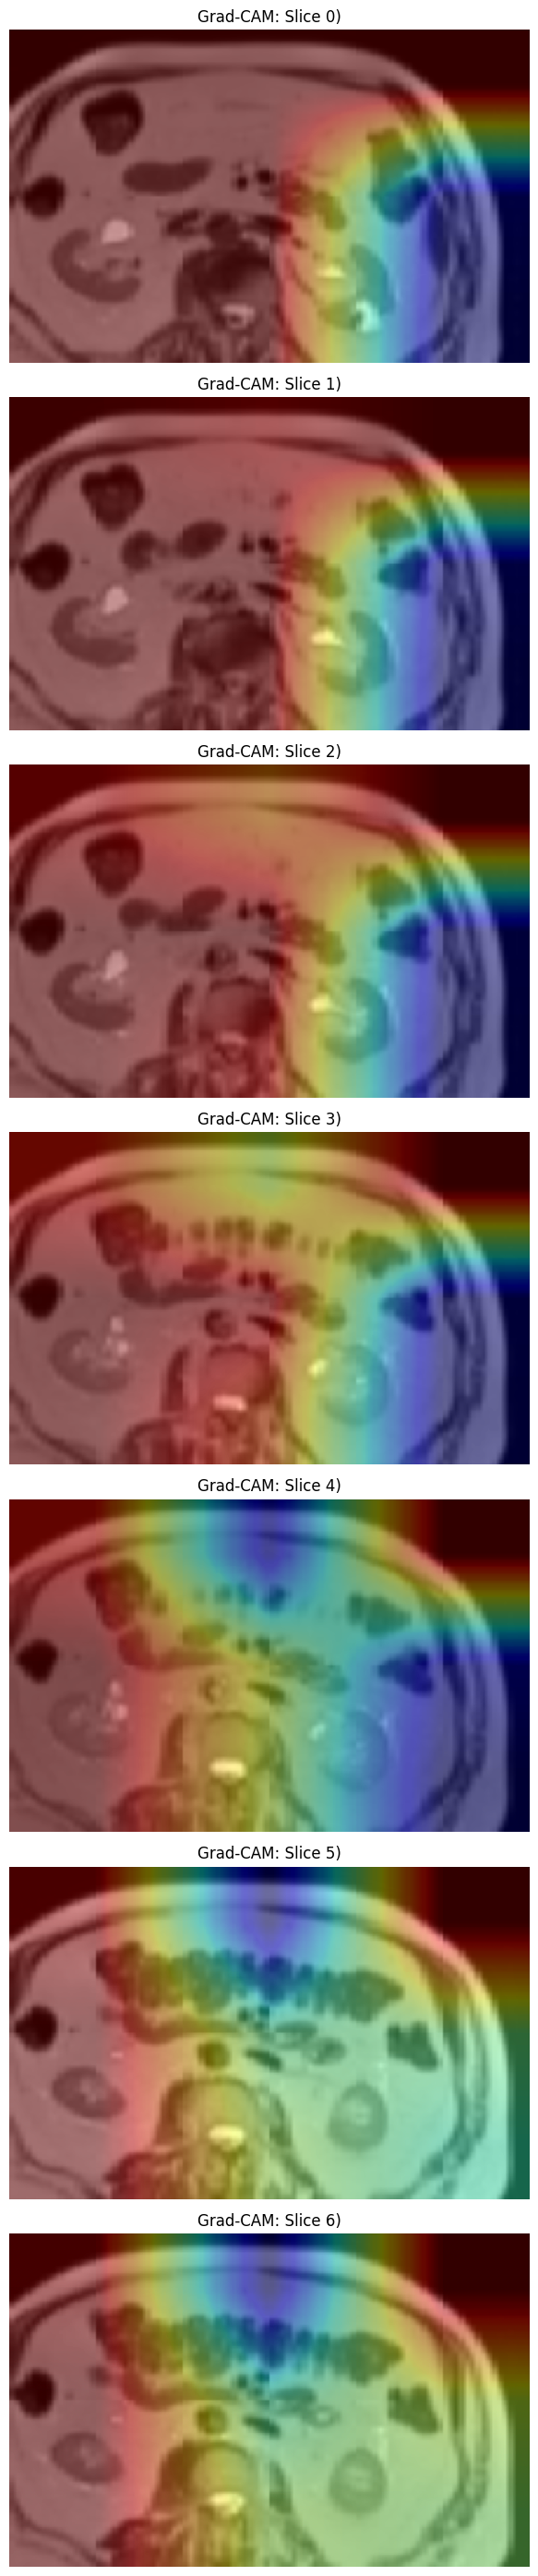

In [6]:
import matplotlib.pyplot as plt
import numpy as np

def overlay_gradcam(original_volume, cam_volume,  alpha=0.5, cmap='hot',rotate = True):

    # Make sure input shape is (H, W, D)
    if original_volume.shape != cam_volume.shape:
        raise ValueError("Shape mismatch: original and CAM volume must match!")


    # Normalize both
    
    num_slices = cam_volume.shape[-1]
    # num_slices=10
    fig, axes = plt.subplots(num_slices, 1, figsize=(6, 4 * num_slices))
    
    

    # Plot
    for i in range(num_slices):
        orig_slice = original_volume[:, :, i]
        cam_slice = cam_volume[:, :, i]

        orig_norm = (orig_slice - orig_slice.min()) / (orig_slice.max() - orig_slice.min() + 1e-5)
        cam_norm = (cam_slice - cam_slice.min()) / (cam_slice.max() - cam_slice.min() + 1e-5)
        if rotate:
            orig_norm = np.rot90(orig_norm, k=3)
            cam_norm = np.rot90(cam_norm, k=3)
        axes[i].imshow(orig_norm, cmap='gray')
        axes[i].imshow(cam_norm, cmap=cmap, alpha=alpha)
        axes[i].axis("off")
        axes[i].set_title(f"Grad-CAM: Slice {i})")
    
    plt.tight_layout()
    plt.show()
    # plt.figure(figsize=(6, 6))
    # plt.imshow(orig_norm, cmap='gray')
    # plt.imshow(cam_norm, cmap=cmap, alpha=alpha)
    # plt.axis("off")
    # plt.title(f"Overlay: Slice {i}")
    # plt.show()

overlay_gradcam(input_tensor, cam_volume,alpha=0.4, cmap='jet',rotate = True)